### CyberSecurity ground truth prediction

In the evolving cybersecurity landscape, the increase in threat actors has overwhelmed enterprise security operation centers (SOCs) with incidents. This situation necessitates solutions for classifying the threat and triggering a remediation process. However, fully automated systems require a very high confidence threshold to avoid errors due to automated actions, making them often impractical. As a result, guided response (GR) systems have been developed to aid SOC analysts in making informed decisions. These guided response systems require a triaged threat assessment that is then prioritized fed into an XDR (extended detection and response system) for review and action by a SOC analyst.

### Objective


The primary objective of the exercise is to accurately predict incident triage grades as true positive (TP), benign positive (BP), and false positive (FP)—based on labeled responses from SOCs of customers. 

Considering that businesses that rely on 24x7 connectivity, a business impact due to mis handling of alerts/incidents (either ignored, or bring down services in response to ones that did not need it) could be huge. As such high precision and a high recall is desired on the predicted for TruePositive and False Positive classifications

### Data

The data set comprises of 13 million pieces of evidence across 33 entity types, covering 1.6 million alerts and 1 million annotated incidents with triage labels from customers over a two-week period. The dataset is built from telemetry from 6100 organizations, using 9100 unique detectors. All data has been anonymized. More information on how this data was prepared, how alerts were corelated into incidents can be found in this whitepaper: https://arxiv.org/abs/2407.09017. The scope of this initiative was much larger - to corelate events, triage prediction and remediation action prediction. My focus is triage prediction only.

The data is available on Kaggle 

https://www.kaggle.com/datasets/Microsoft/microsoft-security-incident-prediction

For the purposes of my analysis (due to compute restrictions, i have limited the data to 100K records)

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, f1_score, confusion_matrix, classification_report, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from imblearn.metrics import specificity_score

from sklearn.ensemble import RandomForestClassifier

# helper library for drawing plots
from plot_helpers import render_plot

pd.set_option('display.max_columns', None)

In [68]:
dtype_spec = {                                  # added to avoid a data load warning about objectives types for these features
    'ActionGrouped': 'object',
    'ActionGranular': 'object'
}

df_train = pd.read_csv('DATA/GUIDE_Train.csv', dtype=dtype_spec, nrows=50000)
df_test = pd.read_csv('DATA/GUIDE_Test.csv', dtype=dtype_spec, nrows=50000)

# Use for local testing with the larger data set which has 13M records. Unable to load this data set into GitHub.
# df_train = pd.read_csv('ORIGINAL-DATA/GUIDE_Train.csv')
# df_test = pd.read_csv('ORIGINAL-DATA/GUIDE_Test.csv')

In [69]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  50000 non-null  int64  
 1   OrgId               50000 non-null  int64  
 2   IncidentId          50000 non-null  int64  
 3   AlertId             50000 non-null  int64  
 4   Timestamp           50000 non-null  object 
 5   DetectorId          50000 non-null  int64  
 6   AlertTitle          50000 non-null  int64  
 7   Category            50000 non-null  object 
 8   MitreTechniques     22334 non-null  object 
 9   IncidentGrade       50000 non-null  object 
 10  ActionGrouped       21 non-null     object 
 11  ActionGranular      21 non-null     object 
 12  EntityType          50000 non-null  object 
 13  EvidenceRole        50000 non-null  object 
 14  DeviceId            50000 non-null  int64  
 15  Sha256              50000 non-null  int64  
 16  IpAd

### Incident/Alert schema
https://learn.microsoft.com/en-us/defender-xdr/advanced-hunting-alertevidence-table

Not all columns in the source schema have been included in the data set provided to us

#### Data description:
- OrgId: ID of the organization from which the data was collected
- IncidentId: ID assigned to the incident. An incident co-relates a set of events
- AlertId: ID assigned to a given alert
- Timestamp: Date and time when the event was recorded
- DetectorID: Detection technology or sensor that identified the notable component or activity
- AlertTitle: Title of the alert
- Category: List of categories that the information belongs to (in this data set, each record only contains one category)
- MitreTechniques: MITRE ATT&CK techniques https://attack.mitre.org/
- IncidentGrade: Labeled data that indicates whether the alert or incident was BP, TP or FP
- ActionGrouped, Action Granular: These correspond to further actions recommended for action by a SOC analyst. These are outside the scope of this project.
- EntityType: Type of object, such as a file, a process, a device, or a user
- EvidenceRole: How the entity is involved in an alert, indicating whether it is impacted or is merely related
- DeviceId: Unique identifier for the device in the service
- Sha256: Hash of the file that the recorded action was applied to
- IpAddress: IP address assigned to the local device used during communication
- Url: URL or fully qualified domain name (FQDN) that was being connected to
- AccountSid: Security Identifier (SID) of the account
- AccountUpn: User principal name (UPN) of the account
- AccountObjectId: Unique identifier for the account
- AccountName: User name of the account
- DeviceName: FQDN of the device
- NetworkMessageId: Unique identifier for the email
- EmailClusterId: ClusterId of ther email server
- RegistryKey: Registry key that the recorded action was applied to
- RegistryValueName: Name of the registry value that the recorded action was applied to
- RegistryValueData: Data of the registry value that the recorded action was applied to
- ApplicationId: Unique identifier for the application
- ApplicationName: Application that performed the recorded action
- OAuthApplicationId: Unique identifier of the third-party OAuth application
- ThreatFamily: Malware family that the suspicious or malicious file or process has been classified under
- FileName: Name of the file that the recorded action was applied to
- FolderPath: Folder containing the file that the recorded action was applied to
- ResourceIdName: Unique identifier of the cloud resource accessed
- ResourceType: Type of cloud resource
- Roles: 
- OSFamily: 
- OSVersion:
- AntispamDirection: 
- SuspicionLevel: 
- LastVerdict: 
- CountryCode
- State
- City




### EDA

In [70]:
df_train.shape, df_test.shape

((50000, 45), (50000, 46))

In [71]:
# The test set has one more column than the train set. find the column that is different between the two data sets
set(df_train.columns).symmetric_difference(set(df_test.columns))

{'Usage'}

In [72]:
# explore the value within the Usage column in the test data set
df_test.Usage.value_counts()


Usage
Public     35177
Private    14823
Name: count, dtype: int64

In [73]:
# This importance of this field has to be verified with a SME. Current interpretation is this column appears 
# to indicate how the test data should be used. Since the column is not present in the training data, it will be 
# removed from the test data
# 
df_test.drop(columns=['Usage'], inplace=True)

In [74]:
# check for missing values in target variable in both data sets
df_train.IncidentGrade.isna().sum(), df_test.IncidentGrade.isna().sum()

(276, 0)

In [75]:
# drop the rows with missing values in the target variable
df_train.dropna(subset=['IncidentGrade'], inplace=True), df_test.dropna(subset=['IncidentGrade'], inplace=True)

(None, None)

In [76]:
df_train.value_counts()

Series([], Name: count, dtype: int64)

In [77]:
#### Columns not needed for this analyis
# This data set has labels for two different needs: initial triage of incidents/alerts, and proposed remediation actions. 
# This objective of my analysis is only to predict a triage ground truth - true positive, benign positive and false positive. 
# As such i will ignore the columsn related to proposed remedation actions ( Last Verdict, ActionGrouped, Action Granualar, LastVerdict, SuspicionLevel)

cat_columns = ['Category', 'EntityType', 'EvidenceRole', 'SuspicionLevel', 'LastVerdict',
               'ResourceType', 'Roles', 'AntispamDirection', 'ThreatFamily']

numerical_columns = ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
                     'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey',
                     'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
                     'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 
                     'OSVersion', 'CountryCode', 'State', 'City']

# create a list to drop additional columns that may not be needed after EDA
drop_columns = []



In [78]:
# convert timestamp to datetime
df_train['Timestamp'] = pd.to_datetime(df_train['Timestamp'])
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])

# this may be useful for forecasting (not in current scope of this project, but may add later)

In [79]:
# Find null values in the dataset
null_values = df_train.isnull().sum()
print(null_values.sort_values(ascending=False))

ActionGrouped         49696
ActionGranular        49696
ResourceType          49680
ThreatFamily          49326
EmailClusterId        49204
AntispamDirection     48836
Roles                 48613
SuspicionLevel        42210
LastVerdict           38019
MitreTechniques       28506
FileName                  0
RegistryValueName         0
RegistryValueData         0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
Id                        0
FolderPath                0
ResourceIdName            0
OSFamily                  0
OSVersion                 0
CountryCode               0
State                     0
RegistryKey               0
DeviceName                0
NetworkMessageId          0
OrgId                     0
IncidentId                0
AlertId                   0
Timestamp                 0
DetectorId                0
AlertTitle                0
Category                  0
IncidentGrade             0
EntityType                0
EvidenceRole        

In [80]:
# Removing columns with more than 80% missing values
drop_columns.extend(['ResourceType', 'ActionGrouped', 'ActionGranular', 'ThreatFamily', 'EmailClusterId', 'Roles', 'AntispamDirection'])
drop_columns

['ResourceType',
 'ActionGrouped',
 'ActionGranular',
 'ThreatFamily',
 'EmailClusterId',
 'Roles',
 'AntispamDirection']

In [81]:
df_train.AlertId.nunique(), df_train.shape

(43547, (49724, 45))

#### Categorical features

<Axes: xlabel='IncidentGrade', ylabel='count'>

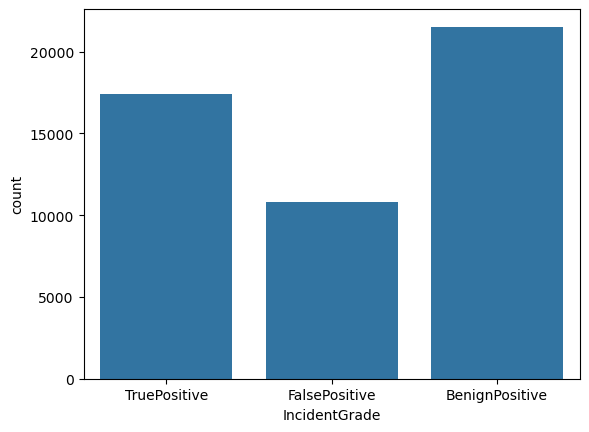

In [82]:
# Explore IncidentGrade
sns.countplot(x='IncidentGrade', data=df_train)

The classes are fairly balanced

In [83]:
# Explore MitreTechniques
df_train.MitreTechniques.value_counts()

# This features includes sub mitres. For the purposes of my analysis, i will ignore the sub mitres and 
# generalize to the higher level mitre
# More information on the Mitre Att$ck framework is here https://attack.mitre.org/

MitreTechniques
T1078;T1078.004                                                                              7193
T1566.002                                                                                    4300
T1566                                                                                        3442
T1133                                                                                         764
T1566.001                                                                                     727
                                                                                             ... 
T1021.002;T1074.002;T1078;T1080;T1543.003;T1569.002;T1570                                       1
T1003;T1005;T1027.002;T1027.005;T1105;T1119;T1539;T1550.004;T1552.001;T1555.003;T1555.004       1
T1027;T1027.002;T1027.005;T1105;T1204.002;T1546.008;T1546.012                                   1
T1016;T1106                                                                                     1
T103

In [84]:
# convert MitreTechniques to extract first technique
df_train['FirstMitreTechnique'] = df_train['MitreTechniques'].str.split(';').str[0]
df_test['FirstMitreTechnique'] = df_test['MitreTechniques'].str.split(';').str[0]

df_train['FirstMitreTechnique'] = df_train['FirstMitreTechnique'].str.split('.').str[0]
df_test['FirstMitreTechnique'] = df_test['FirstMitreTechnique'].str.split('.').str[0]

# add MitreColumns to be dropped later
drop_columns.append('MitreTechniques')

<Axes: xlabel='IncidentGrade', ylabel='count'>

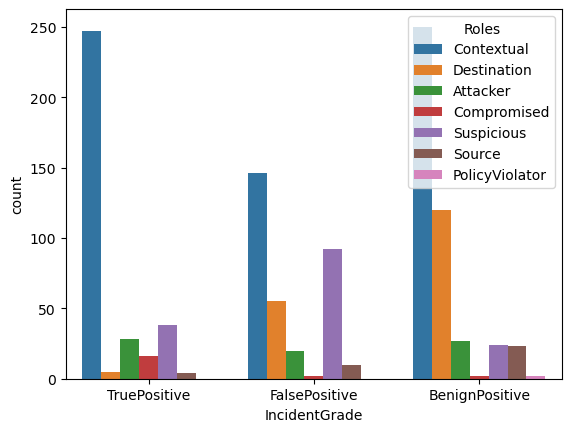

In [85]:
# Explore Roles with IncidentGrade
sns.countplot(x='IncidentGrade', hue='Roles', data=df_train)


In [86]:
# Find all incidents with duplicate AlertIds
duplicate_alerts = df_train[df_train.duplicated('AlertId', keep=False)]

# Show a few sample incidents that are marked true positive
duplicate_alerts[duplicate_alerts['IncidentGrade'] == 'TruePositive'].head(5)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,FirstMitreTechnique
114,670014901898,148,20,32531,2024-06-04 08:45:48+00:00,1264,13900,Exfiltration,NaN,TruePositive,NaN,NaN,File,Impacted,98799,36136,360606,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,60366,31161,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN
142,154618827802,1216,3333,14741,2024-06-11 15:57:54+00:00,10,8,InitialAccess,T1566.001,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,135336,422162,137787,159335,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,T1566
220,927712937952,19,679,2186,2024-06-08 14:13:52+00:00,23,16,CommandAndControl,NaN,TruePositive,NaN,NaN,Url,Related,98799,138268,360606,265,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN
274,738734376941,392,32033,28425,2024-06-04 18:40:59+00:00,1,1,InitialAccess,T1566.002,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,102619,108740,100288,109778,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,T1566
326,764504178755,6,2511,1471,2024-06-02 05:43:28+00:00,17,285,Impact,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,51079,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN


In [87]:
# for the ratio of Category, and show top 10 categories of alerts
df_train['Category'].value_counts(normalize=True).sort_values(ascending=False).head(10)*100

Category
InitialAccess         45.662055
Exfiltration          16.324109
SuspiciousActivity    10.467782
CommandAndControl      8.659802
Impact                 7.921728
CredentialAccess       3.066929
Execution              2.777331
Malware                1.506315
Discovery              1.403749
Persistence            0.697852
Name: proportion, dtype: float64

#### Top categories for logging Incidents and Alerts are InitialAccess, Exfiltration, SuspiciousActivity, CommandA8dControl

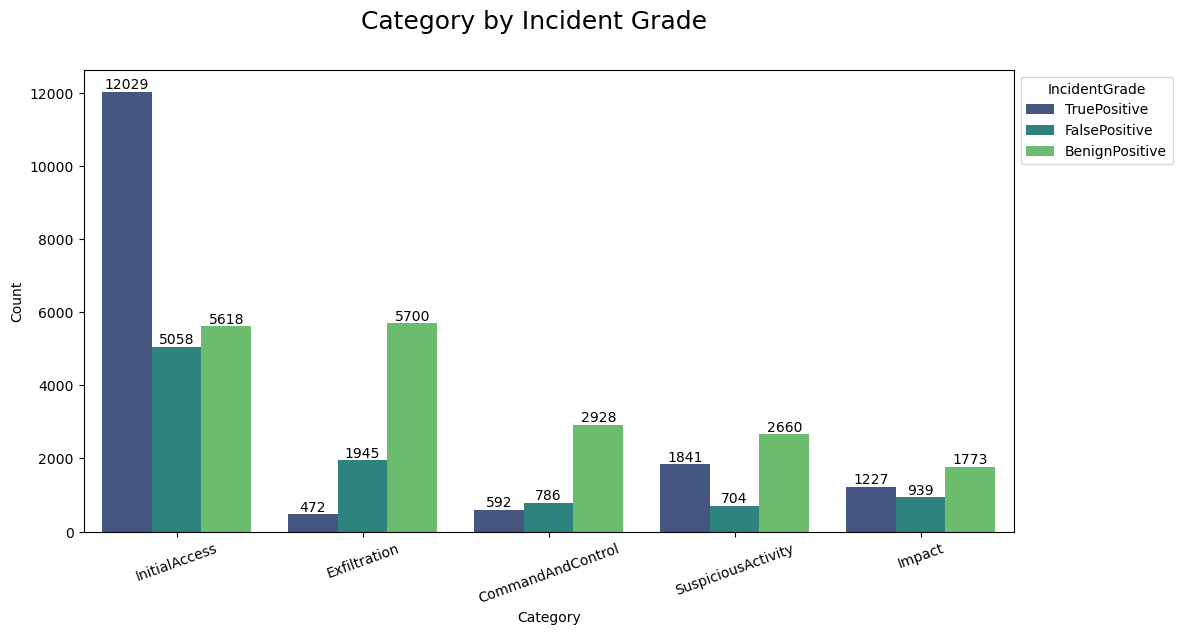

In [88]:
# plot top 5 categories with incident grade

plt.figure(figsize=(12, 6))
top_10_categories = df_train['Category'].value_counts().head(5).index
ax = sns.countplot(data=df_train[df_train['Category'].isin(top_10_categories)], x='Category', hue='IncidentGrade', palette='viridis')

render_plot(ax, heading='Category by Incident Grade', xlabel='Category', ylabel='Count')


Exfiltration attemps appear to be last harmful compared to alerts marked as Initial Access, Suspicious or Impact

#### Last Verdict
https://learn.microsoft.com/en-us/defender-xdr/m365d-remediation-actions

In [89]:
# explore the values within LastVerdict
print(df_train['LastVerdict'].value_counts())


LastVerdict
Suspicious        7324
Malicious         2324
NoThreatsFound    2057
Name: count, dtype: int64


In [90]:
# remove LastVerdict values that begin with 'Domain'
df_last_verdict = df_train[~df_train['LastVerdict'].str.startswith('Domain', na=False)]

In [91]:
# Summarize LastVerdict
print('Number of missing values in Last Verdict are: ', df_last_verdict['LastVerdict'].isna().sum()  )

Number of missing values in Last Verdict are:  38019


In [92]:
# Remove last verdict column, since this is used post the initial triage
drop_columns.append('LastVerdict')

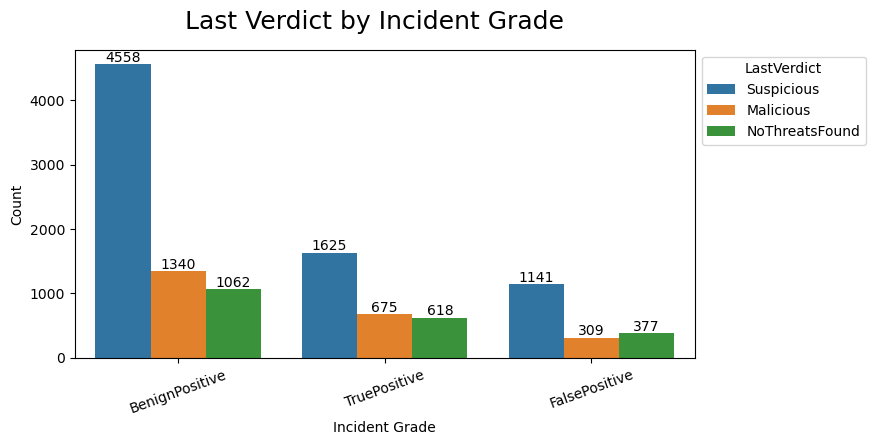

In [93]:
# plot LastVerdict by Incident Grade
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df_last_verdict, x='IncidentGrade', hue='LastVerdict', order=df_last_verdict['IncidentGrade'].value_counts().index)

render_plot(ax, heading='Last Verdict by Incident Grade', xlabel='Incident Grade', ylabel='Count')


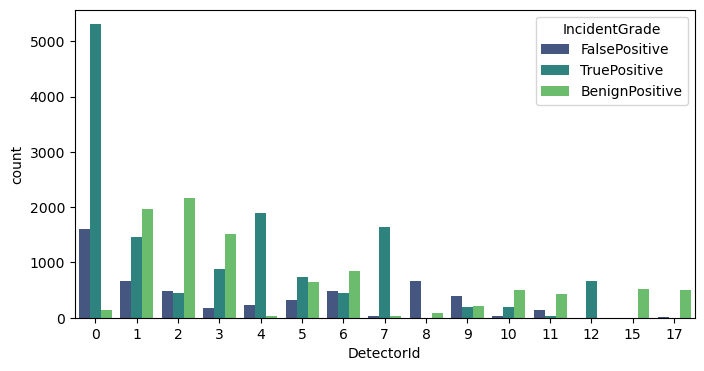

In [94]:
# plot top 10 Detectors by Incident Grade
plt.figure(figsize=(8, 4))
top_10_detectors = df_train['DetectorId'].value_counts().head(15).index
ax = sns.countplot(data=df_train[df_train['DetectorId'].isin(top_10_detectors)], x='DetectorId', hue='IncidentGrade', palette='viridis')

In [95]:
# "DetectorId 0" typically refers to a generic or default detection mechanism, meaning it signifies an alert triggered by a broad security
# rule that isn't specifically tied to a particular security feature or detection method within the XDR platform; it usually indicates a 
# high-level threat that needs further investigation to pinpoint the exact source of the suspicious activity

# check the entity type for DetectorId = 0
df_train[df_train['DetectorId'] == 0]['EntityType'].value_counts()

EntityType
User                 2082
Ip                   1976
CloudLogonRequest    1954
CloudLogonSession    1042
Name: count, dtype: int64

### EntityTypes
https://learn.microsoft.com/en-us/azure/sentinel/entities-reference

In [96]:
# Unique values in EntityType
df_train['EntityType'].value_counts().head(5)

EntityType
Ip             11364
User           10039
MailMessage     6083
Url             3702
Machine         3606
Name: count, dtype: int64

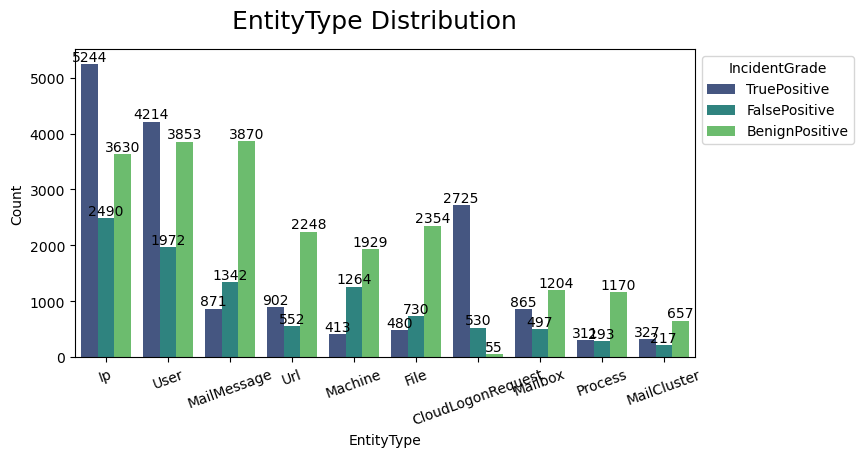

In [97]:
# check the distribution of EntityTypes
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df_train, x='EntityType', hue='IncidentGrade', order=df_train['EntityType'].value_counts().head(10).index, palette='viridis')
render_plot(ax, heading='EntityType Distribution', xlabel='EntityType', ylabel='Count')


In [98]:
# Explore IncidentId 5447

# df_train[df_train['IncidentId'] == 5447]

In [99]:
#"evidencerole" refers to the specific part a particular piece of evidence plays within a security alert, indicating whether 
# it is the primary target of the attack, a related component, or simply provides supporting context for the incident; 
# essentially, it describes how the evidence is involved in the overall threat scenario

df_train.groupby(['IncidentGrade', 'EvidenceRole']).size().sort_values(ascending=False)  

IncidentGrade   EvidenceRole
TruePositive    Related         11293
BenignPositive  Impacted        11277
                Related         10250
TruePositive    Impacted         6125
FalsePositive   Related          5686
                Impacted         5093
dtype: int64

In [100]:
# Explore Mitre Techniques with Incident Grade

df_train.groupby(['FirstMitreTechnique', 'IncidentGrade']).size().sort_values(ascending=False)
# df_sorted = df_grouped.sort_values(by='size', ascending=False)
# df_sorted

FirstMitreTechnique  IncidentGrade 
T1078                TruePositive      5368
T1566                BenignPositive    4368
                     TruePositive      2486
T1078                FalsePositive     1723
T1566                FalsePositive     1630
                                       ... 
T1496                TruePositive         1
T1137                BenignPositive       1
T1490                BenignPositive       1
T1539                FalsePositive        1
T1203                BenignPositive       1
Length: 205, dtype: int64

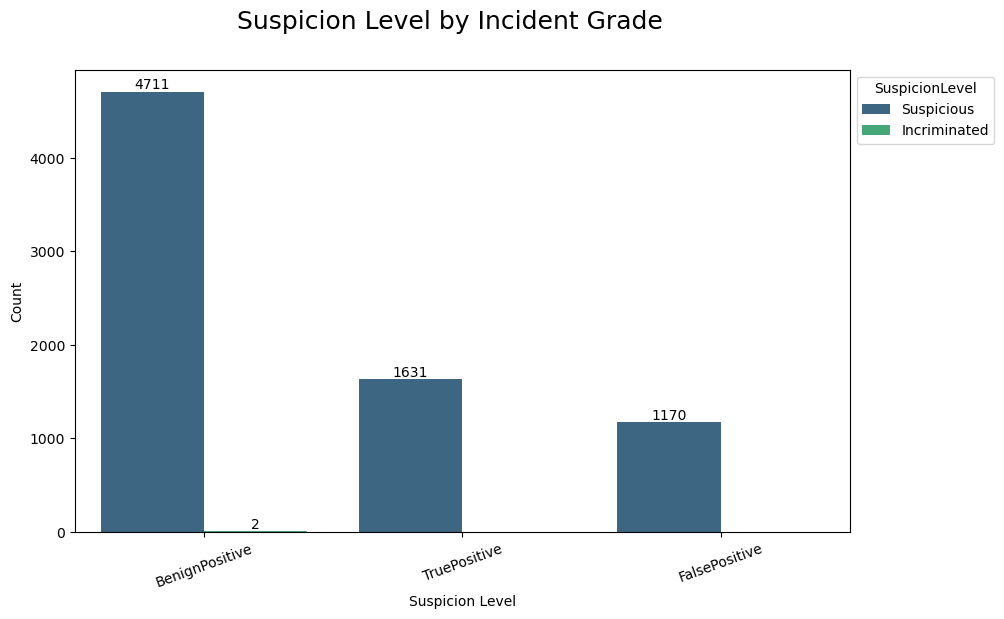

In [101]:
# "suspicion level" refers to the degree of confidence that a detected activity is potentially malicious, 
# often indicated by a "suspicious" verdict within an alert, meaning the system believes there is a high likelihood of a threat 
# but further investigation is needed before taking definitive action; this level can be considered as a 
# middle ground between "clean" (not malicious) and "malicious" (confirmed threat)

# Explore SuspicionLevel feature along with IncidentGrade

# Plot SuspicionLevel with IncidentGrade
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_train, x='IncidentGrade', hue='SuspicionLevel', palette='viridis', order=df_train['IncidentGrade'].value_counts().index)
render_plot(ax, heading='Suspicion Level by Incident Grade', xlabel='Suspicion Level', ylabel='Count')



#### EDA Numerical Data

In [102]:
# Add a numerical feature for IncidentGrade
df_train['IncidentGradeNum'] = df_train['IncidentGrade'].map({'TruePositive': 1, 'FalsePositive': -1, 'BenignPositive': 0})

#drop_columns.append('IncidentGrade')

In [103]:
df_train['IncidentGradeNum'].value_counts()

IncidentGradeNum
 0    21527
 1    17418
-1    10779
Name: count, dtype: int64

In [104]:
# Analyze Geographical Features

num_features_geo = ['CountryCode', 'State', 'City', 'IncidentGradeNum']

# Top 10 countries by Incident Grade
# top_10_countries = df_train['CountryCode'].value_counts().head(10)


# Top 10 countries/state/city by Incident Grade
top_10_country_states = df_train.groupby(['CountryCode', 'State', 'City']).size().reset_index(name='size').sort_values(by='size', ascending=False).head(10)
top_10_country_states

,CountryCode,State,City,size
639,242,1445,10630,45722
221,1,0,0,562
317,5,1445,10630,174
0,0,1,1,117
230,2,2,2,113
1,0,1,5,77
357,10,7,4,68
220,0,1445,10630,66
343,7,8,6,63
367,12,12,9,58


This data set represents region #2 in the XDR data that was released by the provider. It is not suprising to see code 242 as the main contributor of all the indicents in this data set

### Data Clean Up   

In [108]:
# Drop Columns marked in the EDA section

print('Columns to be dropped: ', drop_columns)  

# df_train.drop(columns=drop_columns, axis=1, inplace=True)
# df_test.drop(columns=drop_columns, axis=1, inplace=True)

Columns to be dropped:  ['ResourceType', 'ActionGrouped', 'ActionGranular', 'ThreatFamily', 'EmailClusterId', 'Roles', 'AntispamDirection', 'MitreTechniques', 'LastVerdict']


In [109]:
cat_columns = [col for col in cat_columns if col not in drop_columns]

numerical_columns = [col for col in numerical_columns if col not in drop_columns]

print(cat_columns, numerical_columns)

['Category', 'EntityType', 'EvidenceRole', 'SuspicionLevel'] ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City']


### Train/Test Split

In [110]:
# categorical columns


ohe = OneHotEncoder(handle_unknown='ignore', )
ohe.fit(df_train[cat_columns])

X_train_ohe = ohe.transform(df_train[cat_columns])
X_test_ohe = ohe.transform(df_test[cat_columns])

X_train_ohe_df = pd.DataFrame(X_train_ohe.toarray(), columns=ohe.get_feature_names_out())
X_test_ohe_df = pd.DataFrame(X_test_ohe.toarray(), columns=ohe.get_feature_names_out())

# numerical columns - not scaling them, since these values are not continuous and rather represent various entities, devices etc
X_train_data_numerical = df_train[numerical_columns].fillna(-1)
X_test_data_numerical = df_test[numerical_columns].fillna(-1)

# concatenate data frame
X_train = pd.concat([X_train_ohe_df, X_train_data_numerical.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_ohe_df, X_test_data_numerical.reset_index(drop=True)], axis=1)

In [111]:
X_train.sample(3)

,Category_Collection,Category_CommandAndControl,Category_CredentialAccess,Category_CredentialStealing,Category_DefenseEvasion,Category_Discovery,Category_Execution,Category_Exfiltration,Category_Exploit,Category_Impact,Category_InitialAccess,Category_LateralMovement,Category_Malware,Category_Persistence,Category_PrivilegeEscalation,Category_Ransomware,Category_SuspiciousActivity,Category_UnwantedSoftware,EntityType_ActiveDirectoryDomain,EntityType_AzureResource,EntityType_BlobContainer,EntityType_CloudApplication,EntityType_CloudLogonRequest,EntityType_CloudLogonSession,EntityType_File,EntityType_GenericEntity,EntityType_Ip,EntityType_Machine,EntityType_MailCluster,EntityType_MailMessage,EntityType_Mailbox,EntityType_Malware,EntityType_OAuthApplication,EntityType_Process,EntityType_RegistryKey,EntityType_RegistryValue,EntityType_SecurityGroup,EntityType_Url,EntityType_User,EvidenceRole_Impacted,EvidenceRole_Related,SuspicionLevel_Incriminated,SuspicionLevel_Suspicious,SuspicionLevel_nan,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
25697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,98799,138268,360606,160396,441377,50881,425863,453297,153085,57850,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
22726,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,98799,138268,360606,160396,413162,670600,359734,123646,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
16675,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,98799,138268,360606,160396,441377,673934,425863,112422,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630


In [112]:
y_train = df_train['IncidentGrade']
y_test = df_test['IncidentGrade']

### Basic Classifiers

In [113]:
# helper function to run and evaluate models, pipelines and gridsearchcv

def run_and_eval_model(model, model_name, X_train, X_test, y_train, y_test):
    
    print(f"Fitting {model_name}...")
    start_time = time.time()

    # fit the selected model 
    model.fit(X_train, y_train.values.ravel())
    
    fit_time = round(time.time() - start_time, 2)
    
    print(f"Evaluating {model_name}...")
    start_time = time.time()

    train_score = cross_val_score(model, X_train, y_train.values.ravel(), cv=5, scoring='accuracy').mean()
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro', zero_division=np.nan)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(classification_report(y_test, y_pred))
    
    eval_time = round(time.time() - start_time, 2)
    
    print(f"{model_name} with train accuracy score {train_score:.3f}, took {time.time()-start_time:.3f} seconds")
    
    return {'model': model_name, 
            'train accuracy': train_score, 
            'test accuracy': test_accuracy,
            'precision': precision, 
            'recall': recall,
            'f1': f1,
            'fit time': fit_time,
            'eval time': eval_time}
    
def draw_roc_curves(X_test, y_test, model):
    
    # Create ROC curves for each of the classes

    # Get the predicted probabilities
    y_score = model.predict_proba(X_test)

    # Binarize the output labels for ROC curve
    y_test_bin = pd.get_dummies(y_test)

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(y_test_bin.columns):
        fpr, tpr, _ = roc_curve(y_test_bin[class_name], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for class {class_name}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Fitting Decision Trees...
Evaluating Decision Trees...
                precision    recall  f1-score   support

BenignPositive       0.67      0.71      0.69     21037
 FalsePositive       0.52      0.45      0.48     10966
  TruePositive       0.71      0.71      0.71     17997

      accuracy                           0.66     50000
     macro avg       0.63      0.63      0.63     50000
  weighted avg       0.65      0.66      0.65     50000

Decision Trees with train accuracy score 0.656, took 2.666 seconds


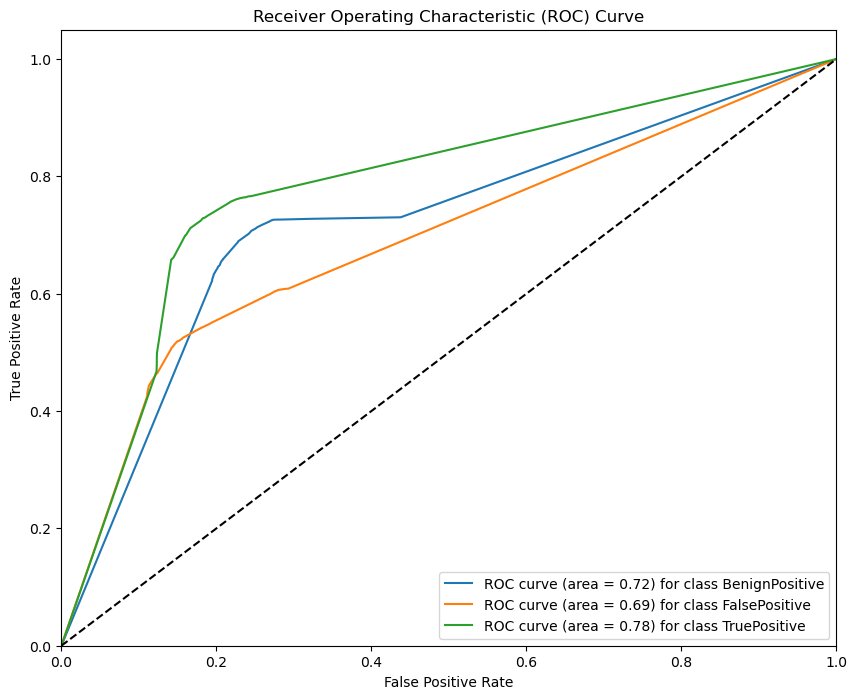

Fitting Random Forest...
Evaluating Random Forest...
                precision    recall  f1-score   support

BenignPositive       0.68      0.77      0.72     21037
 FalsePositive       0.58      0.44      0.50     10966
  TruePositive       0.73      0.72      0.72     17997

      accuracy                           0.68     50000
     macro avg       0.66      0.64      0.65     50000
  weighted avg       0.67      0.68      0.67     50000

Random Forest with train accuracy score 0.682, took 21.158 seconds


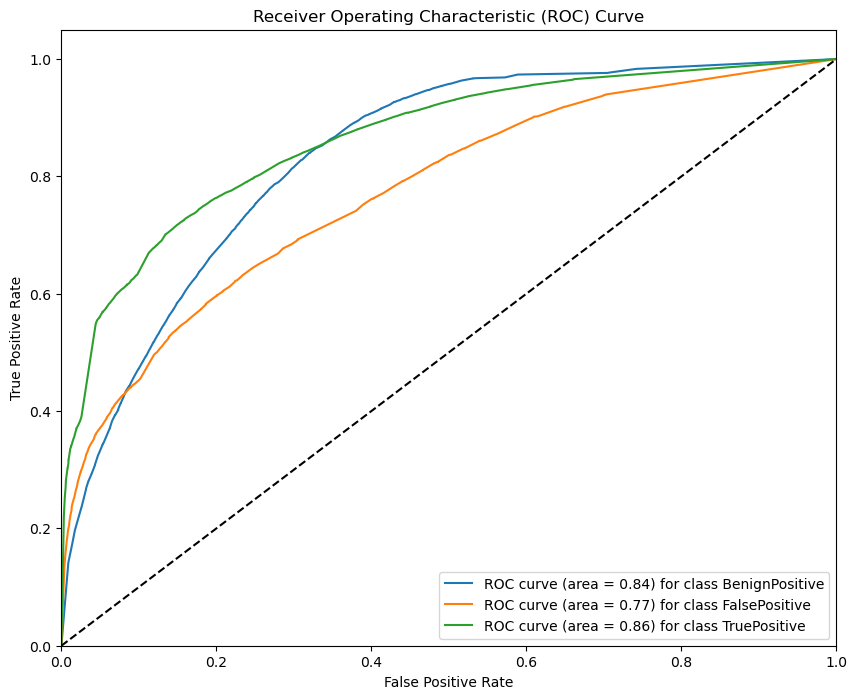

Fitting Logistic Regression...


/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression...


/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

                precision    recall  f1-score   support

BenignPositive       0.59      0.67      0.63     21037
 FalsePositive       0.61      0.14      0.23     10966
  TruePositive       0.56      0.72      0.63     17997

      accuracy                           0.57     50000
     macro avg       0.59      0.51      0.50     50000
  weighted avg       0.58      0.57      0.54     50000

Logistic Regression with train accuracy score 0.564, took 572.762 seconds


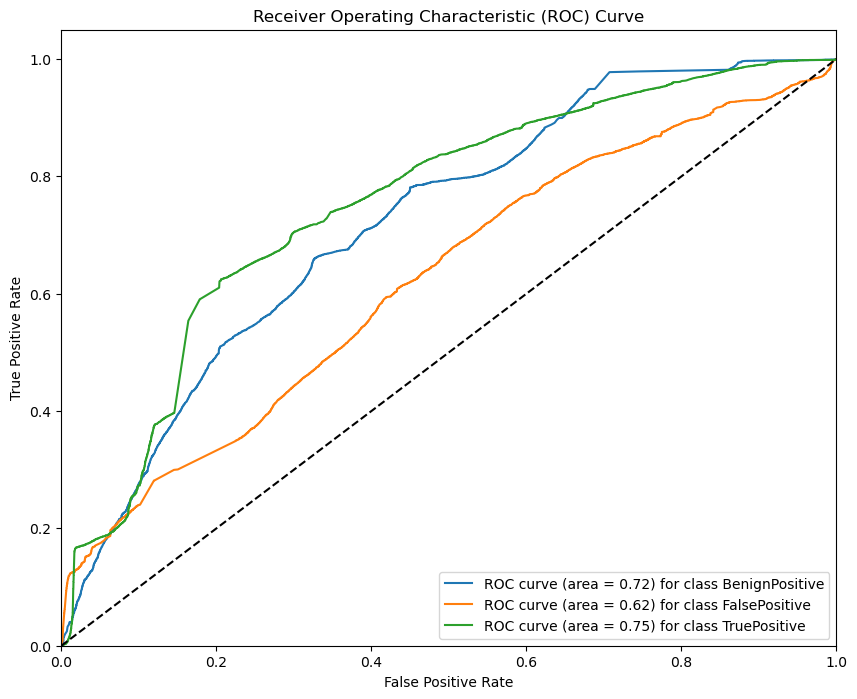

Fitting SVM...
Evaluating SVM...
                precision    recall  f1-score   support

BenignPositive       0.61      0.59      0.60     21037
 FalsePositive       0.61      0.13      0.22     10966
  TruePositive       0.52      0.78      0.62     17997

      accuracy                           0.56     50000
     macro avg       0.58      0.50      0.48     50000
  weighted avg       0.58      0.56      0.53     50000

SVM with train accuracy score 0.548, took 3810.229 seconds


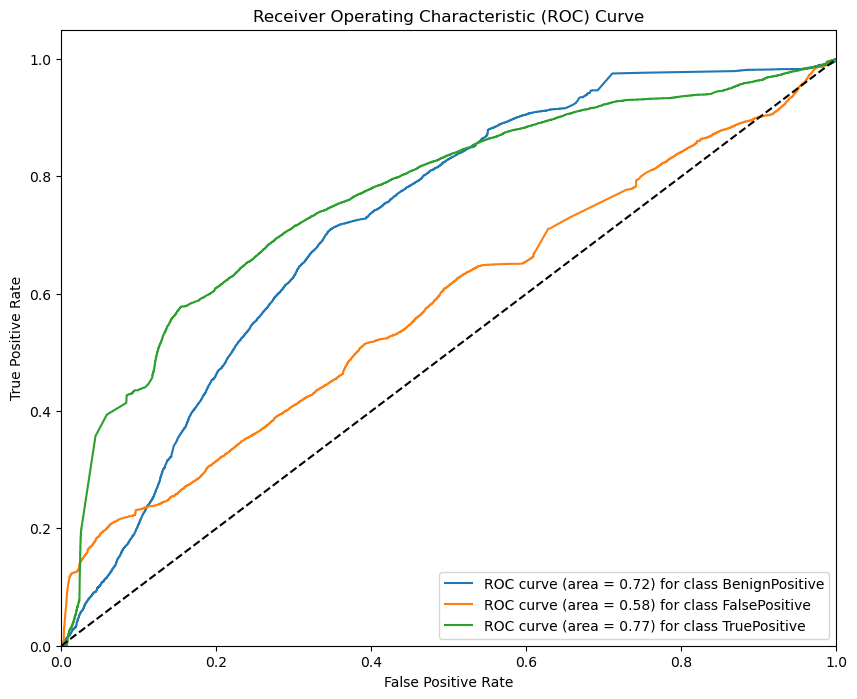

Fitting KNN...
Evaluating KNN...
                precision    recall  f1-score   support

BenignPositive       0.62      0.75      0.68     21037
 FalsePositive       0.49      0.35      0.41     10966
  TruePositive       0.69      0.64      0.67     17997

      accuracy                           0.62     50000
     macro avg       0.60      0.58      0.58     50000
  weighted avg       0.62      0.62      0.61     50000

KNN with train accuracy score 0.622, took 6.649 seconds


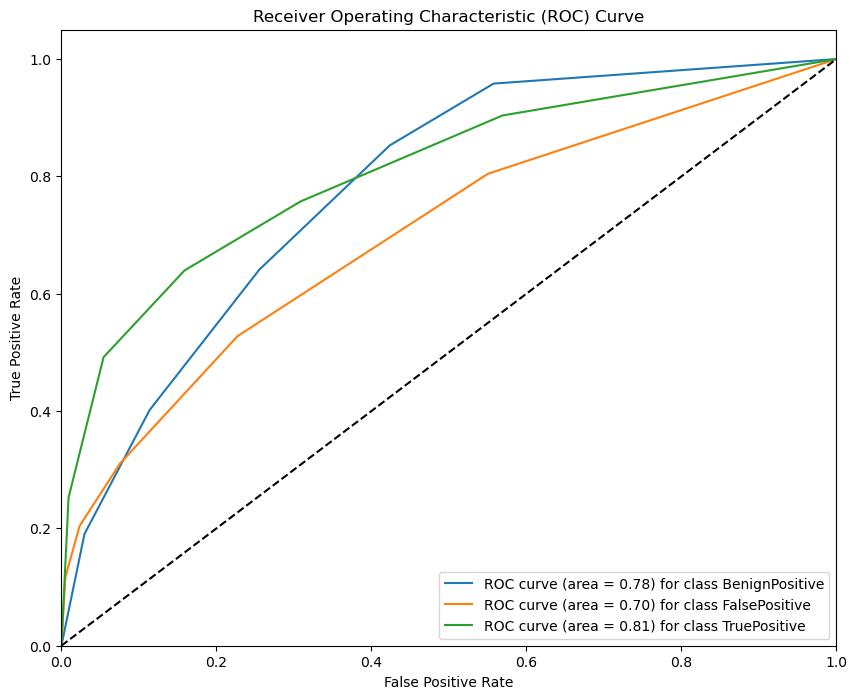

,model,train accuracy,test accuracy,precision,recall,f1,fit time,eval time
0,Decision Trees,0.655961,0.65510,0.632168,0.625532,0.627928,0.28,2.67
1,Random Forest,0.681924,0.67902,0.661021,0.643288,0.648300,4.72,21.16
2,Logistic Regression,0.563812,0.57392,0.585972,0.512205,0.495429,133.03,572.76
3,SVM,0.548186,0.56062,0.579855,0.502996,0.481285,1300.89,3810.23
4,KNN,0.622054,0.62210,0.600086,0.578816,0.582580,0.06,6.65


In [114]:
# Define the pipelines for all classification models with default hyperparameters

pipelines = {
    'Decision Trees': Pipeline([('classifier', DecisionTreeClassifier())]),
    'Random Forest': Pipeline([('classifier', RandomForestClassifier())]),
    'Logistic Regression': Pipeline([('classifier', LogisticRegression(max_iter=10000))]),
    'SVM': Pipeline([('classifier', SVC(decision_function_shape='ovr', probability=True))]),
    'KNN': Pipeline([('classifier', KNeighborsClassifier())])
}

models_evaluated = pd.DataFrame()

for model_name, pipeline in pipelines.items():
    dict = run_and_eval_model(pipeline, model_name, X_train, X_test, y_train, y_test)
    models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)
    draw_roc_curves(X_test, y_test, pipeline)
    
models_evaluated


### Decision Tree

In [115]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)


In [116]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

Accuracy: 0.65532
Macro-Precision: 0.6320707158181645
Macro-Recall: 0.6253719395797828
Macro-F1 Score: 0.6277488581938031


In [117]:
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

BenignPositive       0.67      0.71      0.69     21037
 FalsePositive       0.52      0.45      0.48     10966
  TruePositive       0.70      0.71      0.71     17997

      accuracy                           0.66     50000
     macro avg       0.63      0.63      0.63     50000
  weighted avg       0.65      0.66      0.65     50000



In [118]:
# export the tree
feature_names = dt.feature_names_in_

# clean the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]

# feature important
features_importance = pd.DataFrame({'feature': clean_feature_names, 'importance': dt.feature_importances_})
    
# sort the features by importance
features_importance.sort_values(by='importance', ascending=False).head(10)

depth = export_text(dt, feature_names=clean_feature_names)
export_text(dt, feature_names=clean_feature_names, show_weights=True)

print(depth[0:1000])

|--- Category_InitialAccess <= 0.50
|   |--- Category_Exfiltration <= 0.50
|   |   |--- Category_CommandAndControl <= 0.50
|   |   |   |--- CountryCode <= 74.00
|   |   |   |   |--- Category_Discovery <= 0.50
|   |   |   |   |   |--- IpAddress <= 59595.50
|   |   |   |   |   |   |--- City <= 183.00
|   |   |   |   |   |   |   |--- IpAddress <= 27.00
|   |   |   |   |   |   |   |   |--- IpAddress <= 21.00
|   |   |   |   |   |   |   |   |   |--- City <= 6.50
|   |   |   |   |   |   |   |   |   |   |--- City <= 5.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: TruePositive
|   |   |   |   |   |   |   |   |   |   |--- City >  5.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: TruePositive
|   |   |   |   |   |   |   |   |   |--- City >  6.50
|   |   |   |   |   |   |   |   |   |   |--- class: TruePositive
|   |   |   |   |   |   |   |   |--- IpAddress >  21.00
|   |   |   |   |   |   |   |   |   |--- class: TruePositive
|   |   |   |   |   |   |   |--- IpAddress >  27

In [119]:
features_importance.sort_values(by='importance', ascending=False).head(10)

,feature,importance
46,IpAddress,0.177950
49,AccountUpn,0.114737
10,Category_InitialAccess,0.100808
48,AccountSid,0.089202
47,Url,0.059947
53,NetworkMessageId,0.054590
51,AccountName,0.051230
50,AccountObjectId,0.049636
52,DeviceName,0.046060
60,FileName,0.038823


In [120]:
features_importance.sort_values(by='importance', ascending=False).tail(5)

,feature,importance
20,EntityType_BlobContainer,0.0
32,EntityType_OAuthApplication,0.0
35,EntityType_RegistryValue,0.0
41,SuspicionLevel_Incriminated,0.0
3,Category_CredentialStealing,0.0


In [121]:
tree_depth = dt.tree_.max_depth  

print("Depth of the fitted decision tree:", tree_depth) 

Depth of the fitted decision tree: 80


In [122]:
# setup a GridSearchCV for the Decision Tree model

params = {'dt__min_impurity_decrease': [0.001, 0.01, 0.1, 1.0],
          'dt__max_depth': [5,10,20],
          'dt__min_samples_split': [0.1, 0.05]}

dt_pipe = Pipeline([('dt', DecisionTreeClassifier(random_state = 42))])

dt_grid = GridSearchCV(estimator=dt_pipe, param_grid=params, n_jobs=10, verbose=1)

dt_grid

GridSearchCV(estimator=Pipeline(steps=[('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=10,
             param_grid={'dt__max_depth': [5, 10, 20],
                         'dt__min_impurity_decrease': [0.001, 0.01, 0.1, 1.0],
                         'dt__min_samples_split': [0.1, 0.05]},
             verbose=1)

In [123]:
dt_grid.fit(X_train, y_train)

y_pred = dt_grid.predict(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [124]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

Accuracy: 0.63804
Macro-Precision: 0.6980755219492251
Macro-Recall: 0.5574646695788656
Macro-F1 Score: 0.5426618118766804


In [125]:
dt_grid.best_params_

{'dt__max_depth': 20,
 'dt__min_impurity_decrease': 0.001,
 'dt__min_samples_split': 0.05}

### Random Forest

In [126]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

params = {'n_estimators': [100, 200, 300],
          'max_depth': [10, 20, 30],
          'min_samples_split': [2, 5, 10]}

rf_grid = GridSearchCV(estimator=rfc, param_grid=params, n_jobs=10, verbose=1)

rf_grid

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=10,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [127]:
rf_grid.fit(X_train, y_train)

y_pred = rf_grid.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [128]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

print(classification_report(y_test, y_pred))

Accuracy: 0.70016
Macro-Precision: 0.7217729665661253
Macro-Recall: 0.6469845273227323
Macro-F1 Score: 0.6575913328327321
                precision    recall  f1-score   support

BenignPositive       0.65      0.89      0.75     21037
 FalsePositive       0.73      0.37      0.49     10966
  TruePositive       0.79      0.68      0.73     17997

      accuracy                           0.70     50000
     macro avg       0.72      0.65      0.66     50000
  weighted avg       0.72      0.70      0.69     50000

